In [11]:
from torch.utils.data import Dataset
import torch
import glob
import pandas as pd
from datetime import datetime
import os
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

In [3]:
start_time, end_time = "05/12/2021 00:00", "05/12/2021 00:30"
path = '/home/yhbedoya/Repositories/SHM-MAE/traffic/20211205/'

print(f'reading CSV files')
start = datetime.strptime(start_time, '%d/%m/%Y %H:%M')
end = datetime.strptime(end_time, '%d/%m/%Y %H:%M')

ldf = list()
for p in tqdm(glob.glob(path + "*.csv")):
    name = os.path.split(p)[-1]
    nstr = datetime.strptime(name, 'traffic_%Y%m%dH%H%M%S.csv')
    if start <= nstr < end:
        df_tmp = pd.read_csv(p)
        c_drop = set(df_tmp.columns) - set(["sens_pos", "z", "ts"])
        if len(c_drop) > 0:
            df_tmp.drop(columns=list(c_drop), inplace=True)
        ldf.append(df_tmp)
df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
df.reset_index(inplace=True, drop=True)

#df = df[df['sens_pos'].isin(self.sensors)]
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
data = df

reading CSV files


100%|██████████| 1450/1450 [00:10<00:00, 132.91it/s]


In [4]:
data

,sens_pos,z,ts
0,C1.1.1,-0.988022,2021-12-05 00:00:00.311
1,C1.1.1,-0.988098,2021-12-05 00:00:00.321
2,C1.1.1,-0.988403,2021-12-05 00:00:00.331
3,C1.1.1,-0.987945,2021-12-05 00:00:00.341
4,C1.1.1,-0.988479,2021-12-05 00:00:00.351
...,...,...,...
18894780,C9.2.4,-0.970703,2021-12-05 00:30:00.030
18894781,C9.2.4,-0.971084,2021-12-05 00:30:00.040
18894782,C9.2.4,-0.971313,2021-12-05 00:30:00.050
18894783,C9.2.4,-0.971389,2021-12-05 00:30:00.060


In [2]:
pesaDataDf = pd.read_csv("/home/yhbedoya/Repositories/SHM-MAE/dati_pese_dinamiche/dati 2021-12-04_2021-12-12 pesa km 104,450.csv", sep=";", index_col=0)
pesaDataDf.columns

Index(['Id', 'Ds000IdSite', 'SiteName', 'StartTimeStr', 'LaneNo', 'ClassId',
       'Direction', 'VehicleLength', 'GrossWeight', 'GrossWeightAxle1',
       'GrossWeightAxle2', 'GrossWeightAxle3', 'GrossWeightAxle4',
       'GrossWeightAxle5', 'GrossWeightAxle6', 'GrossWeightAxle7',
       'GrossWeightAxle8', 'GrossWeightAxle9', 'GrossWeightAxle10',
       'GrossWeightAxle11', 'PositionRight', 'PositionLeft', 'Velocity',
       'WheelBase', 'AxlesCount', 'MassUnit', 'VelocityUnit', 'DistanceUnit',
       'TotalLeftImbalance', 'TotalRightImbalance', 'ImbalanceUnit',
       'OverLoad', 'Plate', 'Plate2', 'BetweenLane', 'NamePhoto', 'NamePhoto2',
       'PathPhoto', 'Temperature', 'TemperatureUnit', 'Deflection',
       'DeflectionUnit', 'StrongAccDec'],
      dtype='object')

In [4]:
pesaDataDf = pd.read_csv("/home/yhbedoya/Repositories/SHM-MAE/dati_pese_dinamiche/dati 2021-12-04_2021-12-12 pesa km 104,450.csv", sep=";", index_col=0)
pesaDataDf = pesaDataDf[["Id", "StartTimeStr", "ClassId", "GrossWeight", "Velocity", "VelocityUnit"]]
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["StartTimeStr"])
pesaDataDf["Time"] = pesaDataDf["Time"].dt.strftime('%Y-%d-%m %H:%M:00')
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["Time"]) + pd.to_timedelta(-1,'H')
pesaDataDf["EstimatedTime"] = pesaDataDf["Time"] + pd.to_timedelta(600/(pesaDataDf["Velocity"]/3.6),'S')
pesaDataDf["MaxTime"] = pesaDataDf["EstimatedTime"] + pd.to_timedelta(60,'S')
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["Time"]).dt.strftime('%Y-%m-%d %H:%M:00')
pesaDataDf[(pesaDataDf["Time"]>="2021-12-06 00:00:00") & (pesaDataDf["Time"]<="2021-12-06 23:59:00")]


,Id,StartTimeStr,ClassId,GrossWeight,Velocity,VelocityUnit,Time,EstimatedTime,MaxTime
N.,,,,,,,,,
33715,65483,07/12/2021 00:58,Classe 8,15985,82,Km/h,2021-12-06 23:58:00,2021-12-06 23:58:26.341463415,2021-12-06 23:59:26.341463415
33716,65482,07/12/2021 00:55,Classe 8,14455,81,Km/h,2021-12-06 23:55:00,2021-12-06 23:55:26.666666667,2021-12-06 23:56:26.666666667
33717,65481,07/12/2021 00:55,Classe 1,1875,135,Km/h,2021-12-06 23:55:00,2021-12-06 23:55:16.000000000,2021-12-06 23:56:16.000000000
33718,65480,07/12/2021 00:54,Classe 1,2710,139,Km/h,2021-12-06 23:54:00,2021-12-06 23:54:15.539568345,2021-12-06 23:55:15.539568345
33719,65479,07/12/2021 00:53,Classe 1,1390,93,Km/h,2021-12-06 23:53:00,2021-12-06 23:53:23.225806452,2021-12-06 23:54:23.225806452
...,...,...,...,...,...,...,...,...,...
39408,59790,06/12/2021 01:27,Classe 1,1160,94,Km/h,2021-12-06 00:27:00,2021-12-06 00:27:22.978723404,2021-12-06 00:28:22.978723404
39409,59789,06/12/2021 01:26,Classe 2,5620,91,Km/h,2021-12-06 00:26:00,2021-12-06 00:26:23.736263736,2021-12-06 00:27:23.736263736
39410,59788,06/12/2021 01:23,Classe 1,1385,88,Km/h,2021-12-06 00:23:00,2021-12-06 00:23:24.545454545,2021-12-06 00:24:24.545454545


(array([1726., 1257., 1034.,  934.,  883.,  823.,  589.,  593.,  448.,
         355.,  292.,  206.,  190.,  129.,   81.,   73.,   63.,   35.,
          37.,   25.,   12.,    9.,    5.,    8.,    3.,    2.,    4.,
           0.,    3.,    2.]),
 array([ 1.        ,  1.96666667,  2.93333333,  3.9       ,  4.86666667,
         5.83333333,  6.8       ,  7.76666667,  8.73333333,  9.7       ,
        10.66666667, 11.63333333, 12.6       , 13.56666667, 14.53333333,
        15.5       , 16.46666667, 17.43333333, 18.4       , 19.36666667,
        20.33333333, 21.3       , 22.26666667, 23.23333333, 24.2       ,
        25.16666667, 26.13333333, 27.1       , 28.06666667, 29.03333333,
        30.        ]),
 <BarContainer object of 30 artists>)

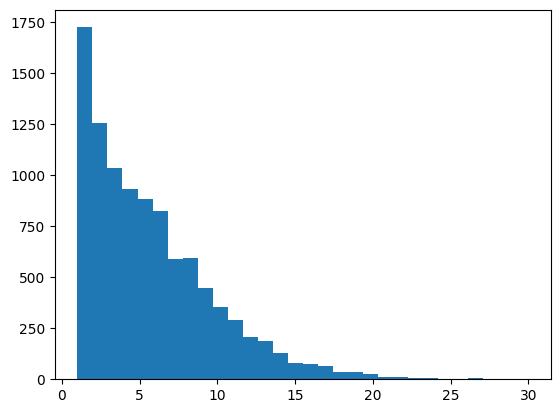

In [13]:
count = pesaDataDf.groupby("Time").count()["Id"]
plt.hist(count, bins=30)

In [8]:
pesaDataDf = pd.read_csv("/home/yhbedoya/Repositories/SHM-MAE/dati_pese_dinamiche/dati 2021-12-04_2021-12-12 pesa km 104,450.csv", sep=";", index_col=0)
pesaDataDf = pesaDataDf[["Id", "StartTimeStr"]]
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["StartTimeStr"])
pesaDataDf["Time"] = pesaDataDf["Time"].dt.strftime('%Y-%d-%m %H:%M:00')
pesaDataDf["Time"] = pd.to_datetime(pesaDataDf["Time"]) + pd.to_timedelta(-1,'H') 
aggDf = pesaDataDf.groupby(["Time"])["Id"].count()
labelsDf = aggDf.reset_index()
labelsDf["Time"] = pd.to_datetime(labelsDf["Time"]).dt.strftime('%Y-%m-%d %H:%M:00')
labelsDf.rename(columns={"Id": "Vehicles"}, inplace=True)
labelsDf

KeyboardInterrupt: 

In [15]:
labelsDf[(labelsDf["Time"]>="2021-12-04 23:55:00") & (labelsDf["Time"]<="2021-12-05 00:30:00")]

,Time,Vehicles
1081,2021-12-04 23:55:00,3
1082,2021-12-04 23:56:00,1
1083,2021-12-04 23:57:00,1
1084,2021-12-05 00:03:00,3
1085,2021-12-05 00:04:00,2
1086,2021-12-05 00:05:00,1
1087,2021-12-05 00:06:00,1
1088,2021-12-05 00:07:00,1
1089,2021-12-05 00:09:00,2
1090,2021-12-05 00:10:00,1


In [9]:
def _transformation(slice):
    sliceN = slice-torch.mean(slice)
    frequencies, times, spectrogram = signal.spectrogram(sliceN,sampleRate,nfft=frameLength,noverlap=(frameLength - stepLength), nperseg=frameLength,mode='psd')

    return frequencies, times, np.log10(spectrogram)

def _normalizer(spectrogram):
    spectrogramNorm = (spectrogram - min) / (max - min)
    return spectrogramNorm

def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [1, 49], fs=fs, btype='band')

def butter_bandpass_filter(slice, lowcut, highcut, fs, order=5):
    sliceN = slice-np.mean(np.array(slice))
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, sliceN)
    return y

In [43]:
sampleRate = 100
frameLength = 256
stepLength = 64
windowLength= 6000
windowStep = 1500

sensors = data['sens_pos'].unique().tolist()
print(f'start partitioner')
partitions = {}
cumulatedWindows = 0
limits = dict()
print(f'Generating windows')
for sensor in tqdm(sensors):
    if sensor != "C1.1.2":
        continue
    sensorData = data[data['sens_pos']==sensor]
    totalFrames = sensorData.shape[0]
    totalWindows = math.ceil((totalFrames-windowLength)/windowStep)
    start = cumulatedWindows
    cumulatedWindows += totalWindows
    end = cumulatedWindows
    indexStart = sensorData.index[0]
    partitions[sensor]= (start, end, indexStart)

timeData = torch.tensor(data["z"].values, dtype=torch.float64)
timestamps =  np.array(data["ts"].values)
#vehiclesData = data["Vehicles"]
cummulator = -1
posCummulator = 0
negCummulator = 0


mins = list()
maxs = list()
print(f'Defining useful windows limits')
noiseFreeSpaces = 1
for index in tqdm(range(0, cumulatedWindows)):
    for k,v in partitions.items():
        if index in range(v[0], v[1]):
            start = v[2]+(index-v[0])*windowStep
            filteredSlice = butter_bandpass_filter(timeData[start: start+windowLength], 0, 50, sampleRate)
            amp = np.max(filteredSlice)-np.min(filteredSlice)
            if True:
                posCummulator +=1 
                cummulator += 1
                #label = vehiclesData[start : start+windowLength].mean()
                limits[cummulator] = (start, start+windowLength, amp, timestamps[start])
                slice = timeData[start:start+windowLength]
                frequencies, times, spectrogram = _transformation(torch.tensor(slice, dtype=torch.float64))
                mins.append(np.min(np.array(spectrogram)))
                maxs.append(np.max(np.array(spectrogram)))
                noiseFreeSpaces += 1
                
            elif noiseFreeSpaces>0:
                negCummulator +=1
                cummulator += 1
                #label = vehiclesData[start : start+windowLength].mean()
                limits[cummulator] = (start, start+windowLength, amp)
                slice = timeData[start:start+windowLength]
                frequencies, times, spectrogram = _transformation(torch.tensor(slice, dtype=torch.float64))
                mins.append(np.min(np.array(spectrogram)))
                maxs.append(np.max(np.array(spectrogram)))
                noiseFreeSpaces -= 1
            break
print(f'Total windows in dataset: {cummulator}')
min = np.min(np.array(mins))
max = np.max(np.array(maxs))
print(f'Total positive instances: {posCummulator}')
print(f'Total noisy instances: {negCummulator}')
print(f'Proportion of useful instances {(posCummulator+negCummulator)/cumulatedWindows}')       
print(f'General min: {min}')
print(f'General max: {max}')

start partitioner
Generating windows


100%|██████████| 105/105 [00:00<00:00, 176.88it/s]


Defining useful windows limits


100%|██████████| 116/116 [00:00<00:00, 928.60it/s]

Total windows in dataset: 115
Total positive instances: 116
Total noisy instances: 0
Proportion of useful instances 1.0
General min: -17.353365175742226
General max: -4.353973361509182


In [24]:
def __getitem__(index):
    start, end, std, timestamp = limits[index]
    slice = timeData[start:end]
    frequencies, times, spectrogram = _transformation(slice)
    spectrogram = torch.unsqueeze(torch.tensor(spectrogram, dtype=torch.float64), 0)
    
    return frequencies, times, spectrogram, std, timestamp


In [38]:
import matplotlib.pyplot as plt

def plotSpect(frequencies, times, spectrogram, index, std, timestamp):
    plt.figure(figsize=(10, 5))
    plt.title(f'spectrogram from PSD: {round(std, 4)} Time: {timestamp}')
    plt.pcolormesh(times, frequencies, 10*(np.squeeze(spectrogram)), vmin=-150, vmax=-50)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(format="%+2.f", label='dB')
    #folder = "positives" if std > 0.0075 else "noise"
    plt.savefig(f'/home/yhbedoya/Repositories/SHM-MAE/LabelTest/C1.1.2/{index}.png')
    plt.close()

In [44]:
for i in range(len(limits)):
    frequencies, times, spectrogram, std, timestamp = __getitem__(i)
    plotSpect(frequencies, times, spectrogram, i, std, timestamp)